In [2]:
import pickle

from functions.cleaning import cleaning_rf
from functions.preprocessor import preprocessor

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Import of clean data

In [3]:
df = cleaning_rf()

In [4]:
X = df.drop(columns=['EVENT_LABEL'])
y = df['EVENT_LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)

In [5]:
df.head()

,transaction_amt,transaction_adj_amt,historic_velocity,currency,cvv,signature_image,transaction_type,transaction_env,tranaction_initiate,inital_amount,EVENT_LABEL,day,month,browser,os,acc_age,d_last_logon
0,2167.0,56.0,2572.0,cad,D,F,U,X,O,13646.0,0,Tue,Dec,Opera,Windows,4,3
1,2045.0,48.0,4517.0,cad,X,X,H,W,J,11930.0,0,Tue,Jun,Opera,Linux,3,1
2,2892.0,61.0,5007.0,cad,X,Q,X,X,T,7412.0,0,Mon,May,Mozilla,Linux,7,5
3,3040.0,28.0,6022.0,usd,G,G,C,N,M,4623.0,0,Thu,Mar,Mozilla,Macintosh,3,2
4,2976.0,66.0,2600.0,cad,X,F,F,G,K,1905.0,0,Sat,Mar,Mozilla,Linux,4,2


## Preprocessor

In [6]:
preprocessor = preprocessor(X_train)

## Model

In [7]:
MLPClass = MLPClassifier(random_state=42)

# Random forest classifier

## Undersampling

### Under sampler

In [8]:
under_sampler = RandomUnderSampler()

### Pipeline

In [26]:
u_mlp = Pipeline([('under_sampler', under_sampler),
                 ('preprocesor', preprocessor),
                 ('MLP', MLPClass)])

In [10]:
results = cross_validate(u_mlp, X_train, y_train,cv=5, return_train_score = True, scoring='recall_macro')
print(f'Average Train Score: {results['train_score'].mean()}')
print(f'Average Test Score: {results['test_score'].mean()}')

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. T

Average Train Score: 0.9424251408264628
Average Test Score: 0.868589489113891


In [60]:
u_grid = {'MLP__hidden_layer_sizes': [(100),
                                      (200),
                                      (50),
                                      (300),
                                      (400),
                                      (200, 100),
                                      (100, 50, 25),
                                      (200, 100, 50)],
        'MLP__learning_rate_init': [0.001, 0.01],
        'MLP__activation': ['relu', 'tanh'],
        'MLP__max_iter': [250]
}

In [61]:
u_grid_search = GridSearchCV(estimator=u_mlp, param_grid=u_grid, cv=5, scoring='recall_macro', return_train_score=True)
u_grid_search.fit(X_train, y_train)
print(f'Average Train Score: {u_grid_search.cv_results_['mean_train_score'].mean()}')
print(f'Average Test Score: {u_grid_search.cv_results_['mean_test_score'].mean()}')

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. T

Average Train Score: 0.9498596753413451
Average Test Score: 0.8775583513118559


Convergence visualization

In [62]:
u_grid_search.best_estimator_

Pipeline(steps=[('under_sampler', RandomUnderSampler()),
                ('preprocesor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['currency', 'cvv', 'signature_image', 'transaction_type',
       'transaction_env', 'tranaction_initiate', 'day', 'month', 'browser',
       'os'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['transaction_amt', 'transaction_adj_amt', 'historic_velocity',
       'inital_amount', 'acc_age', 'd_last_logon'],
      dtype='object'))])),
                ('MLP',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=300,
                               max_iter=250, random_state=42))])

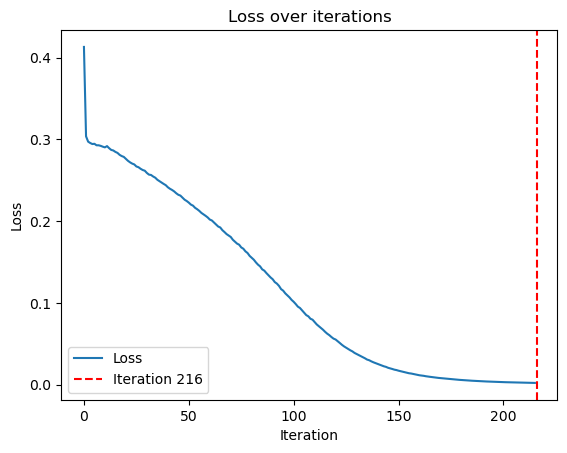

In [63]:
plt.plot([x for x in range(0, u_grid_search.best_estimator_[2].n_iter_)],u_grid_search.best_estimator_[2].loss_curve_, label='Loss')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.axvline(x=u_grid_search.best_estimator_[2].n_iter_, color='r', linestyle='--', label=f'Iteration {u_grid_search.best_estimator_[2].n_iter_}')
plt.legend()
plt.show()

## Oversampling

### Over sampler

In [14]:
over_sampler = SMOTE()

### Pipeline

In [15]:
o_mlp = Pipeline([('preprocessor', preprocessor),
                 ('over_sampler', over_sampler),
                 ('MLP', MLPClass)])

In [16]:
#results = cross_validate(o_mlp, X_train, y_train, return_train_score = True, scoring='recall_macro')
#print(f'Average Train Score: {results['train_score'].mean()}')
#print(f'Average Test Score: {results['test_score'].mean()}')

In [17]:
o_mlp.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['currency', 'cvv', 'signature_image', 'transaction_type',
       'transaction_env', 'tranaction_initiate', 'day', 'month', 'browser',
       'os'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['transaction_amt', 'transaction_adj_amt', 'historic_velocity',
       'inital_amount', 'acc_age', 'd_last_logon'],
      dtype='object'))])),
                ('over_sampler', SMOTE()),
                ('RandomForest', MLPClassifier(random_state=42))])

# Export

In [66]:
with open('models/under_mlp.pkl', 'wb') as f:
    pickle.dump(u_grid_search, f)
f.close()

In [65]:
with open('models/over_mlp.pkl', 'wb') as f:
    pickle.dump(o_mlp, f)
f.close()